In [9]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

import pickle
import json
import sys
import numpy.random as random
sys.path.append("../../../")

import time 

from src.online_prediction import OnlinePredictor
from src.context_aware.models import createModel

In [10]:
rawDatasetFolder = "../../../data/raw"
configPath = "../../config/combined_flows_forward.json"
modelFolder = "../../../data/models/context_aware"
trafficDataFolder = "../../../data/processed/dpdr"
verbose = True

In [11]:
config = json.load(open(configPath))
name = config.get("NAME")
len_window = config.get("LEN_WINDOW")
dim_data =  len(config.get("CONTEXT_IDXS"))

In [12]:
csv_data = pd.read_csv(f"{trafficDataFolder}/{name}.csv")

with open(f"{modelFolder}/{name}_lenWindow_{len_window}_modelConfig.pkl", "rb") as f:
    modelConfig = pickle.load(f)
with open(f"{modelFolder}/{name}_lenWindow_{len_window}_metaConfig.pkl", "rb") as f:
    metaConfig = pickle.load(f)

metaConfig.display()

model, device = createModel(modelConfig)
model.load_checkpoint(f"{modelFolder}/{name}_lenWindow_{len_window}.pth")

MetaConfig:
  dim_data: 12
  window_length: 20
  history_length: 100
  smooth_fc: 1.5
  degree: 3
  Ts: 0.01
  min_vals: [-0.36894907  0.90292435 -0.38260963 -0.41950114  0.89724432 -0.50256594
 -0.44173692  0.89601395 -0.50351072 -0.37503843  0.99577361 -0.40302067]
  max_vals: [ 0.49172105  1.1641571  -0.03381354  0.52639037  1.1625885  -0.1044017
  0.52653422  1.13691496 -0.10175204  0.42422338  1.16192049 -0.034515  ]


In [13]:
onlinePredictor = OnlinePredictor(model, metaConfig)

traffic_recieved_list = []
traffic_predicted_list = []

last_time = time.time()
last_window_time = time.time()
count = 0
N_count = 5000
while True:
    if time.time() - last_time > metaConfig.Ts:
        # ==================== transmiter ====================
        last_time = time.time()
        transmission = csv_data.iloc[count, 1]
        data_point = csv_data.iloc[count, 2:].values
        count += 1            
        if count >= N_count:
            break
        # ==================== receiver ====================
        # Invoked upon receiving a new data point
        if int(transmission) == 1:
            onlinePredictor.receive(data_point)

        # Invoked every window_length * Ts seconds
        if time.time() - last_window_time > metaConfig.window_length * metaConfig.Ts:
            last_window_time = time.time()
            traffic_predicted, traffic_recieved = onlinePredictor.predict()
            traffic_predicted = np.round(traffic_predicted,0).astype(int)
            traffic_recieved_list.append(traffic_recieved)
            traffic_predicted_list.append(traffic_predicted)
            
traffic_recieved_list = np.array(traffic_recieved_list).reshape(-1)
traffic_predicted_list = np.array(traffic_predicted_list).reshape(-1)

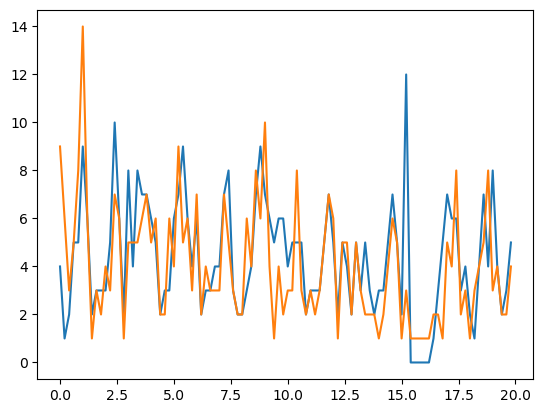

In [17]:
N_display = min(100, len(traffic_recieved_list))
timestamp = np.arange(len(traffic_recieved_list)) * metaConfig.Ts * metaConfig.window_length
plt.plot(timestamp[:N_display], traffic_recieved_list[:N_display])
plt.plot(timestamp[:N_display], traffic_predicted_list[:N_display])
plt.show()